In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset, repeat_channels
from metrics import compute_metrics
from training import train
from evaluation import plot_spectrogram_slices, plot_spectrograms, plot_spectrogram_with_predictions, evaluate_model
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [3]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 100  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.6  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train/validation and test sets
train_val_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)
print("Train indices:", list(train_indices))
print("Val indices:", list(val_indices))
print("Test indices:", list(test_indices))

train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                   file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                   overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_indices)
val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Train indices: [86, 6, 43, 68, 27, 38, 7, 65, 29, 4, 87, 19, 53, 36, 51, 66, 59, 28, 37, 84, 77, 1, 16, 64, 30, 32, 62, 69, 17, 49, 79, 18, 24, 74, 57, 50, 56, 92, 11, 34, 73, 45, 54, 47, 89, 71, 82, 41, 76, 60, 48, 88, 2, 3, 80, 35, 46, 70, 90, 42, 20, 85, 9, 81, 21, 33, 75]
Val indices: [23, 83, 58, 5, 78, 52, 15, 31, 12, 63, 8, 93, 13, 14, 91, 61, 25]
Test indices: [40, 22, 55, 72, 0, 26, 39, 67, 10, 44]


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4347
Shot numbers: [72966, 64401, 70390, 71292, 64770, 70382, 64646, 71264, 64778, 64392, 72967, 64673, 71192, 70380, 71189, 71265, 71225, 64774, 70381, 72964, 72927, 64376, 64666, 71260, 64820, 70355, 71256, 71300, 64668, 71186, 72929, 64670, 64682, 72920, 71223, 71188, 71222, 73022, 64650, 70357, 72919, 70392, 71193, 70394, 73019, 72196, 72961, 70388, 72926, 71226, 71182, 73018, 64378, 64389, 72930, 70359, 70393, 71303, 73020, 70389, 64675, 72965, 64648, 72959, 64677, 70356, 72925]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1029
Shot numbers: [64680, 72963, 71224, 64394, 72928, 71190, 64664, 64834, 64658, 71259, 64647, 73023, 64659, 64662, 73021, 71255, 64684]


In [4]:
# check proportion of positive samples in train set
j = 0
for i in range(len(train_loader.dataset) - 1):
    j += train_loader.dataset[i]['label']
pos_proportion = j / len(train_loader.dataset)
print(f"proportion of positive samples in train set: {pos_proportion.item():.3%}, {1/pos_proportion.item():.3f}")

proportion of positive samples in train set: 18.127%, 5.516


In [6]:
# ResNet18 -- 11M params
model = timm.create_model('resnet18', pretrained=True, drop_rate=0.2)

# replace classifier layer for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),  # output one value
    nn.ReLU(),
    nn.Linear(256, 1),
)

summary(model.to('cpu'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
          Identity-7           [-1, 64, 56, 56]               0
              ReLU-8           [-1, 64, 56, 56]               0
          Identity-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

In [7]:
num_epochs = 7

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/pos_proportion]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

training on device 'mps'


Epoch 0:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.895, f1: 0.735, kappa: 0.670, best threshold: 0.630
     Validation accuracy: 0.920, f1: 0.723, kappa: 0.676, best threshold: 0.680


Epoch 1:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.949, f1: 0.858, kappa: 0.827, best threshold: 0.810
     Validation accuracy: 0.940, f1: 0.774, kappa: 0.739, best threshold: 0.870


Epoch 2:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.965, f1: 0.902, kappa: 0.881, best threshold: 0.810
     Validation accuracy: 0.949, f1: 0.810, kappa: 0.781, best threshold: 0.860


Epoch 3:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.973, f1: 0.925, kappa: 0.908, best threshold: 0.750
     Validation accuracy: 0.949, f1: 0.816, kappa: 0.786, best threshold: 0.860


Epoch 4:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.977, f1: 0.937, kappa: 0.923, best threshold: 0.730
     Validation accuracy: 0.948, f1: 0.809, kappa: 0.779, best threshold: 0.870


Epoch 5:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.979, f1: 0.943, kappa: 0.930, best threshold: 0.680
     Validation accuracy: 0.951, f1: 0.820, kappa: 0.792, best threshold: 0.850


Epoch 6:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.979, f1: 0.943, kappa: 0.931, best threshold: 0.740
     Validation accuracy: 0.949, f1: 0.814, kappa: 0.785, best threshold: 0.850


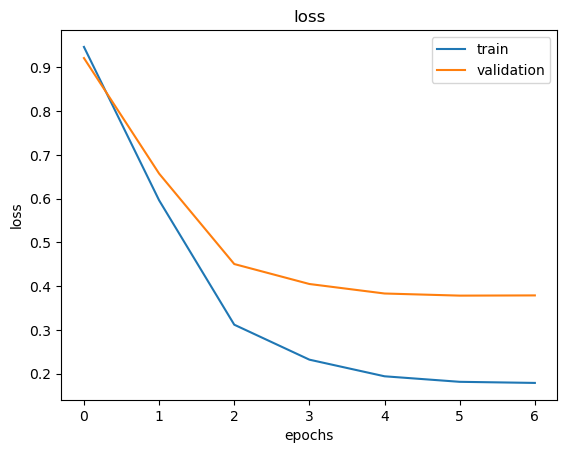

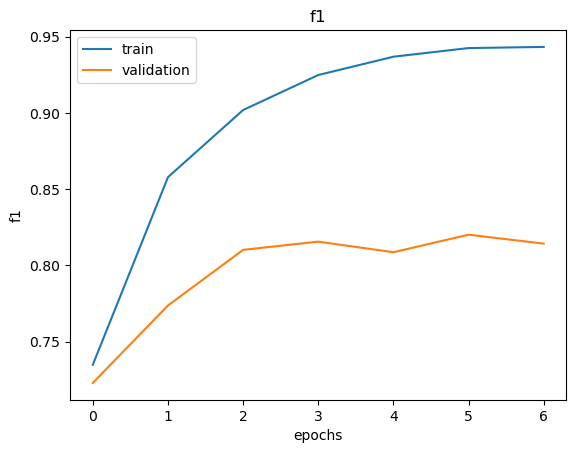

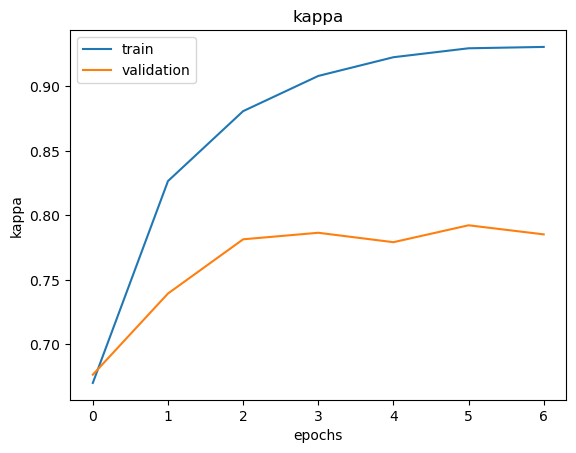

best threshold over validation set: 0.85


(0.9432534678436317,
 0.8142857142857143,
 0.9305922939936069,
 0.7852481518048499,
 0.74,
 0.85)

In [8]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)

## Evaluating the model & visualizing predictions

In [9]:
WINDOW_SIZE = 100
OVERLAP = OVERLAP_FACTOR
test_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP, transform=transform, shot_filter=test_indices)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/10 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 758
Shot numbers: [70387, 64678, 71194, 72198, 64374, 64686, 70383, 71266, 64649, 70391]


In [12]:
# evaluate model on test set
accuracy, f1, kappa = evaluate_model(model, test_loader, device, threshold=0.5)
print(f"Test Accuracy: {accuracy:.3f}, F1: {f1:.3f}, Kappa: {kappa:.3f}")

Evaluating:   0%|          | 0/2 [00:00<?, ?batch/s]

Test Accuracy: 0.872, F1: 0.774, Kappa: 0.687


Considering test shots: [71194, 70391]


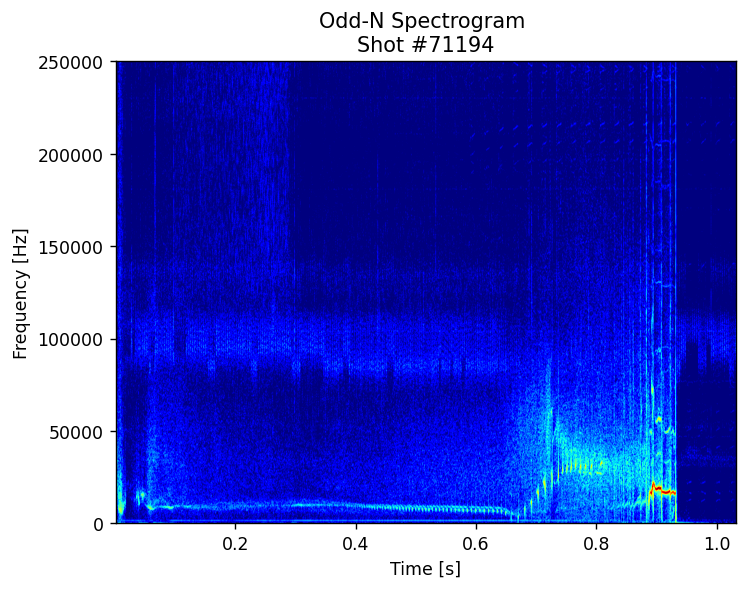

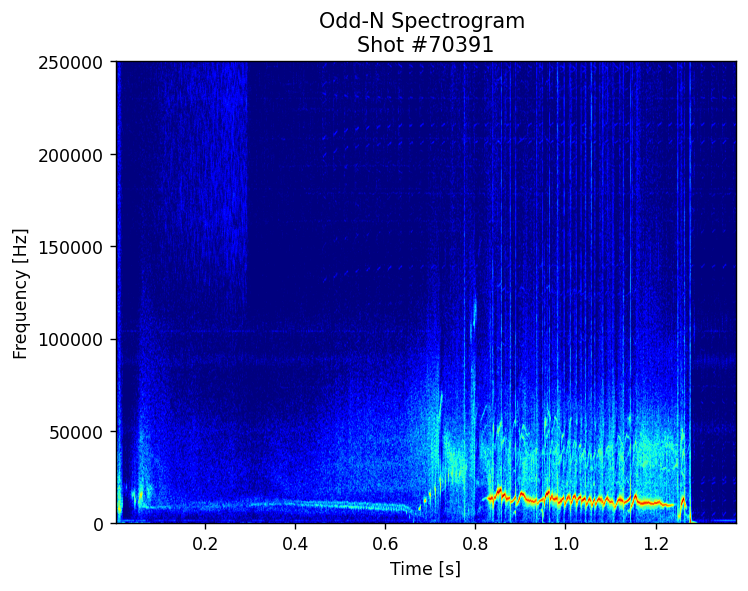

In [13]:
# let's check some random shots from the test set
np.random.seed(1)
shotnos = list(np.random.choice(test_loader.dataset.shotnos, size=2, replace=False))
print(f"Considering test shots: {shotnos}")

plot_spectrograms(shotnos, DATA_PATH, FILE_EXT)

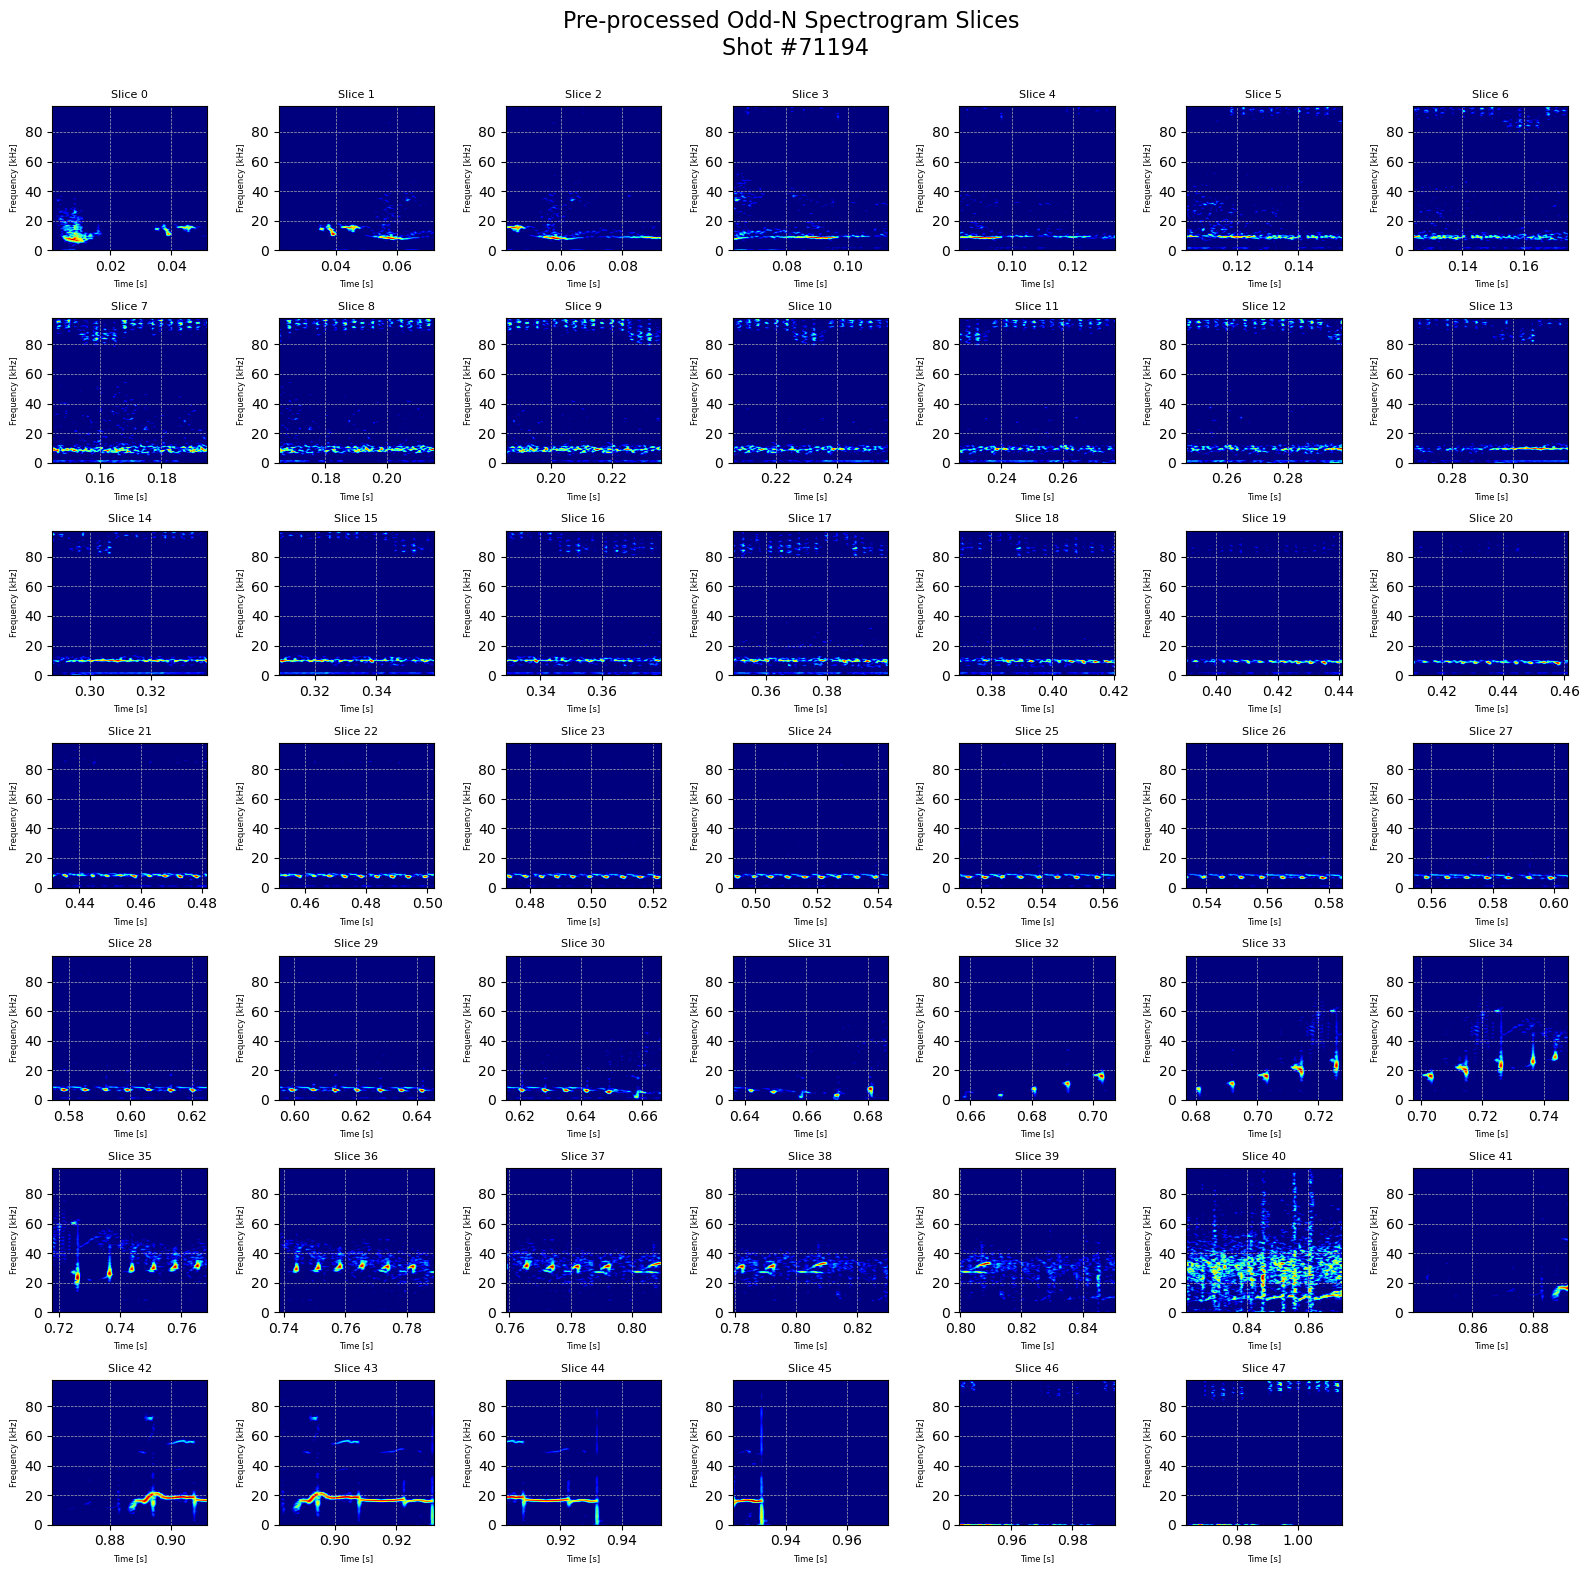

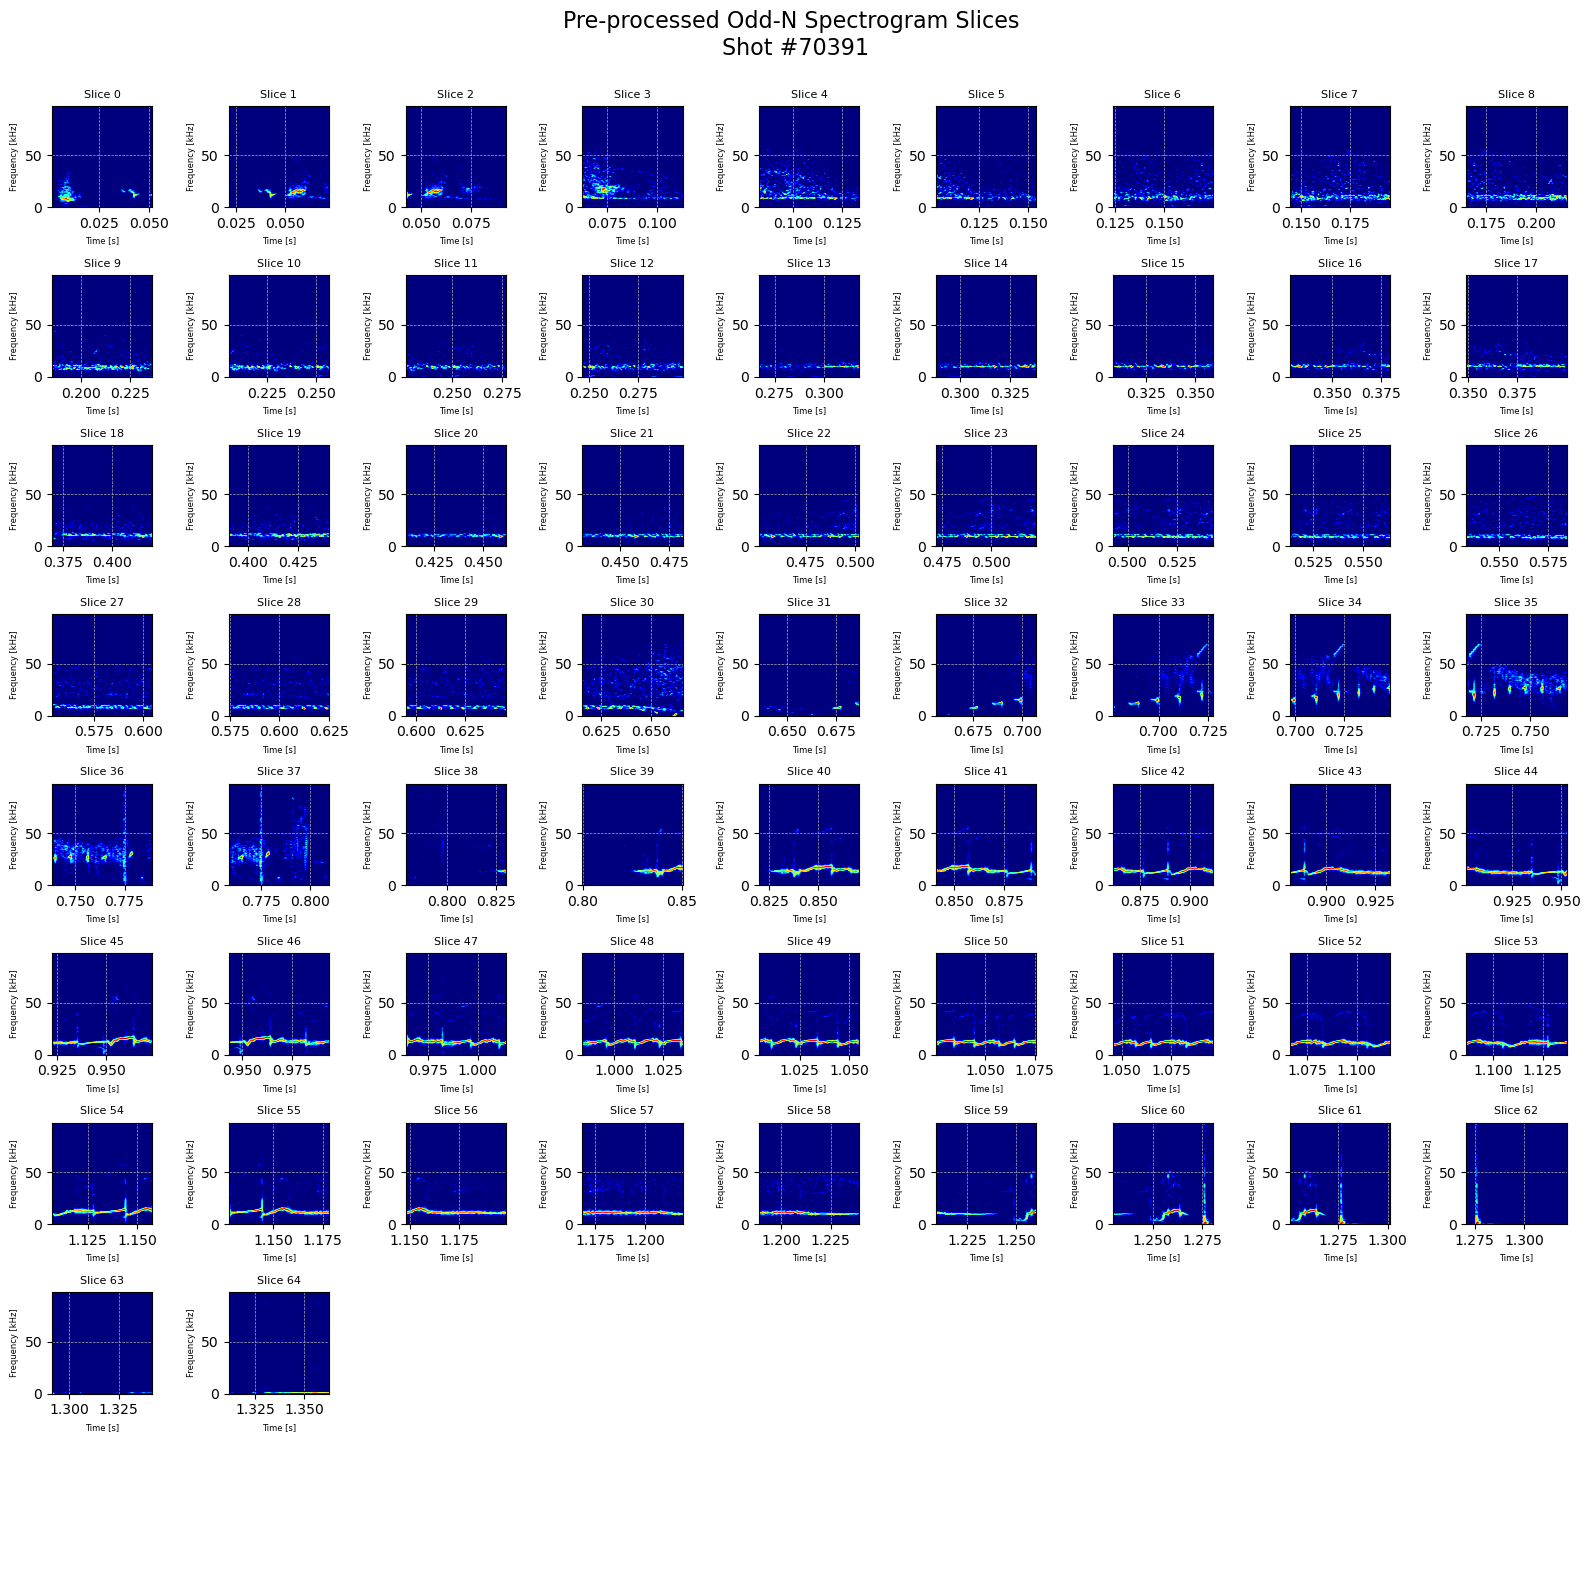

In [14]:
plot_spectrogram_slices(test_loader, shotnos)

Processing 48 slices for shot number 71194


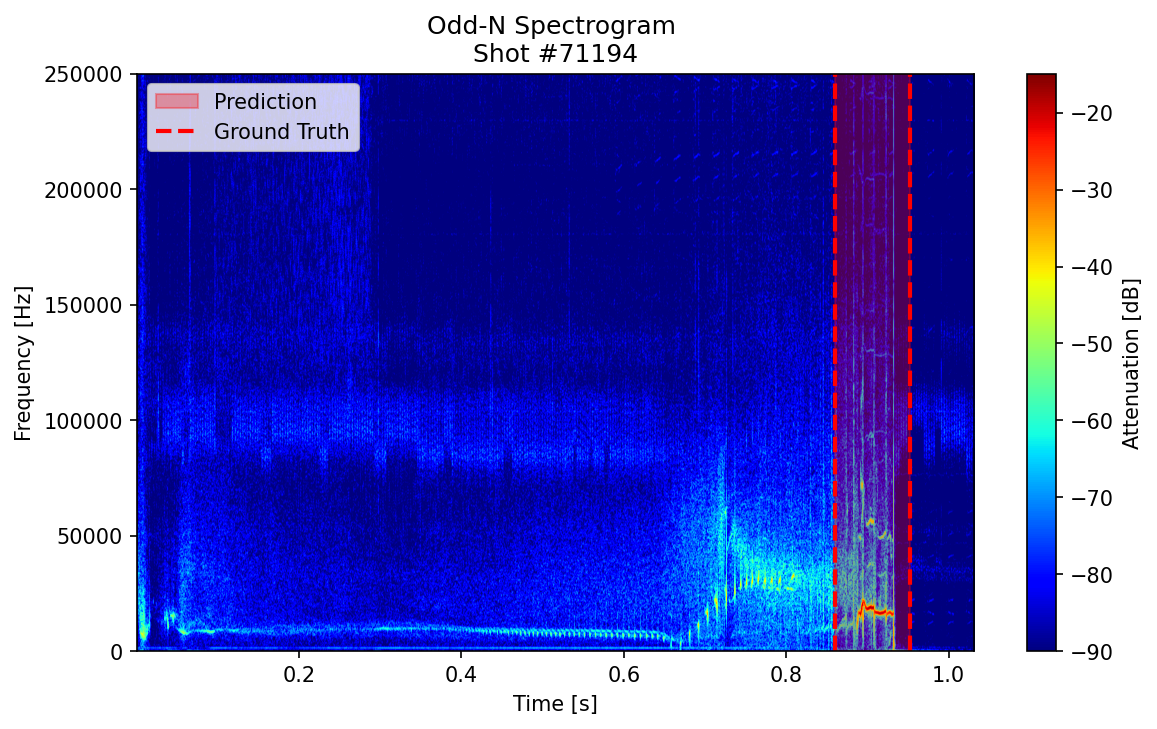

Processing 65 slices for shot number 70391


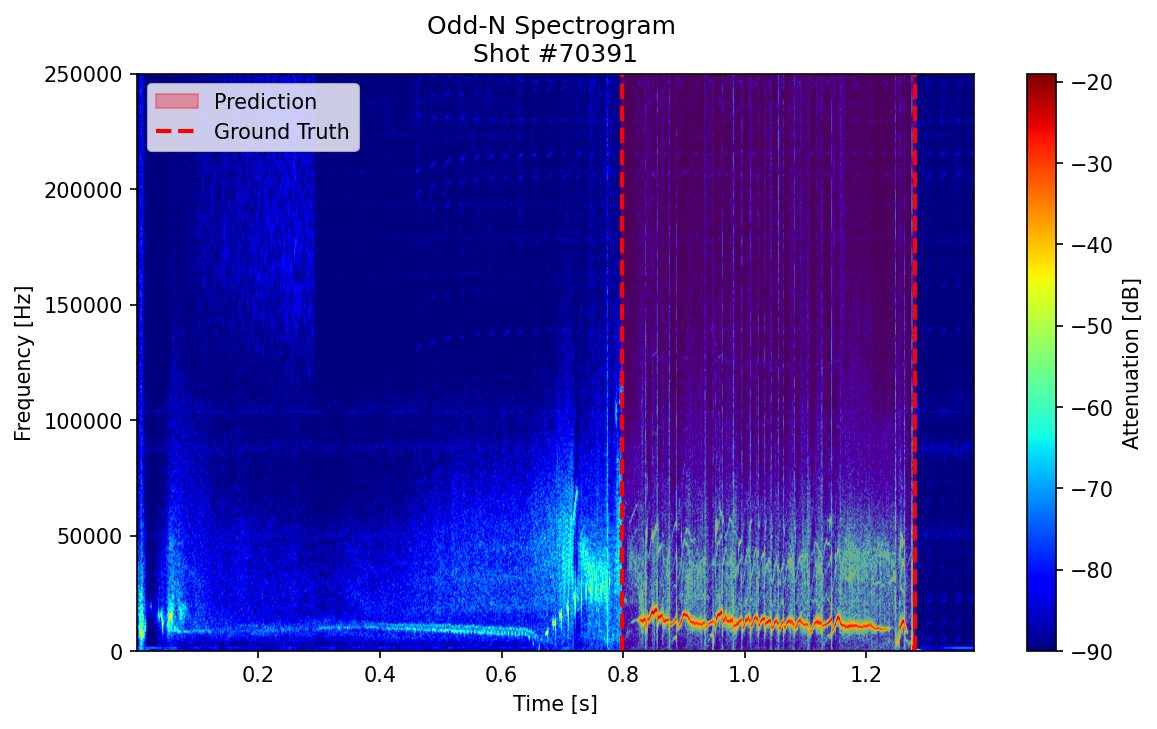

In [16]:
plot_spectrogram_with_predictions(shotnos, DATA_PATH, FILE_EXT, model, test_loader, device, WINDOW_SIZE, OVERLAP, threshold=0.85)